# Simulation

In this notebook, we will simulate raw MEG data with epileptic spikes that we will use to test the pipelines and in the other examples. For the simulation we use MNE-Python [sample dataset](https://mne.tools/stable/overview/datasets_index.html#sample).

First, we import the `simulation` module and other packages. NOTE: To import the `simulation` we should change the working directory if we are running this example from the cloned GitHub repository.


In [1]:
import os
from pathlib import Path

import matplotlib.pylab as plt
import mne
import numpy as np

from nilearn import plotting
import nibabel as nb

# change to the root directory of the project
if os.getcwd().split("/")[-1] == "exapmles_work_in_progress":
    os.chdir('..')
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

from megspikes.simulation.simulation import Simulation

# Setup the path for the simulation
sample_path = Path(os.getcwd()) / 'examples' / 'data'
sample_path.mkdir(exist_ok=True, parents=True)

%load_ext autoreload
%autoreload 2

/Users/valery/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Create new Simulation class instance

In [87]:
# 15 events for each spike shape
n_events = [15, 15, 15, 15]

# all spike shape are simulated in the separate time
simultaneous = [False]*4

sim = Simulation(sample_path, n_events=n_events,
                 simultaneous=simultaneous)
sim

Simulation

Spike shapes file location: /Users/valery/MEG-SPIKES/megspikes/megspikes/simulation/data/spikes.npy
Simulated case parent folder: /Users/valery/MEG-SPIKES/megspikes/examples/data
Events ids: {'spike_shape_1': 1, 'spike_shape_2': 2, 'spike_shape_3': 3, 'spike_shape_4': 4}
Number of each event type: 15, 15, 15, 15
Events locations: G_temp_sup-G_T_transv-rh, G_temp_sup-G_T_transv-lh, S_subparietal-rh, S_subparietal-lh
Events activations: 120, 120, 120, 120

## Spike shapes

For the simulation we use four different spike shapes extracted from the stereo-EEG recording. `sim.activations` contains the list with labels and amplitudes for each spike shape. In the next cell we plot spike shapes and the peak for each spike shape. We will use this peaks to annotate simulated raw data and estimate signal to noise ratio.

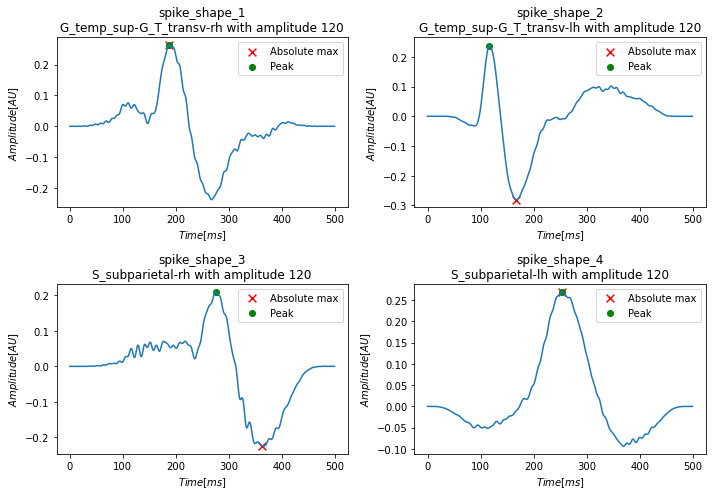

In [88]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
for i, (key, var) in zip(range(4), sim.activations.items()):
    axi = ax.flatten()[i]
    axi.plot(sim.spike_shapes[i])
    axi.scatter(
        sim.max_times[i], sim.spike_shapes[i][sim.max_times[i]],
        c='r', marker='x', s=60, label='Absolute max')
    peak = int(sim.peak_times[i]*1000)
    axi.scatter(
        peak, sim.spike_shapes[i][peak], c='g', marker='o', label='Peak')
    axi.legend()
    axi.set_title(f"{key}\n{var[0][0]} with amplitude {var[0][1]}")
    axi.set_xlabel("$Time [ms]$")
    axi.set_ylabel("$Amplitude [AU]$")
plt.tight_layout()
plt.show()

## Simulate raw

To simulate raw data we follow the MNE-Python [tutorial](https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html). We simulate raw data and dataset by calling `sim.simulate_dataset`.

In [89]:
# multiply the noise covarince by the scaler
noise_scaler = 1

# simulate dataset
sim.simulate_dataset(noise_scaler=noise_scaler)

# filter simulated raw data
sim.raw_simulation.filter(2, 90)

/Users/valery/MEG-SPIKES/megspikes/megspikes/casemanager/casemanager.py:152: UserWarning: No tsss fif file
  sensors: Union[str, bool] = True) -> None:


<RawArray | 306 x 59500 (59.5 s), ~142.1 MB, data loaded>

`sim.simulate_dataset` function added the annotation for the simulated raw data at the peak. We can view the simulated raw data using `mne.io.Raw.plot()`.

In [ ]:
%matplotlib qt5

sim.raw_simulation.plot(block=True);

Using the annotation we can create epochs for each channel type. Note that we have 14 events instead of 15 for the fist and the last simulated spikes shape. This happens beause there is no one second window around the first and the last event in the simulation.

In [90]:
events = mne.events_from_annotations(sim.raw_simulation)
epochs_grad = mne.Epochs(
    sim.raw_simulation, events[0], events[1], tmin=-0.5, tmax=0.5,
    baseline=None, preload=True, reject_by_annotation=False,
    proj=False, picks='grad')
epochs_mag = mne.Epochs(
    sim.raw_simulation, events[0], events[1], tmin=-0.5, tmax=0.5,
    baseline=None, preload=True, reject_by_annotation=False,
    proj=False, picks='mag')
print(epochs_mag, '\n', epochs_grad)

<Epochs |  58 events (all good), -0.5 - 0.5 sec, baseline off, ~48.2 MB, data loaded,
 'SRC1': 14
 'SRC2': 15
 'SRC3': 15
 'SRC4': 14> 
 <Epochs |  58 events (all good), -0.5 - 0.5 sec, baseline off, ~93.5 MB, data loaded,
 'SRC1': 14
 'SRC2': 15
 'SRC3': 15
 'SRC4': 14>


We can plot the average simulated events for the __spike shape 4__.

In [ ]:
%matplotlib inline
epochs_grad['SRC4'].average().plot();

## Plot sources locations


We can plot the locations of the labels on the glass brain. Later we will call this as a __resection area__ and use this locations as ground truth to compare with the results of our detection pipelines.

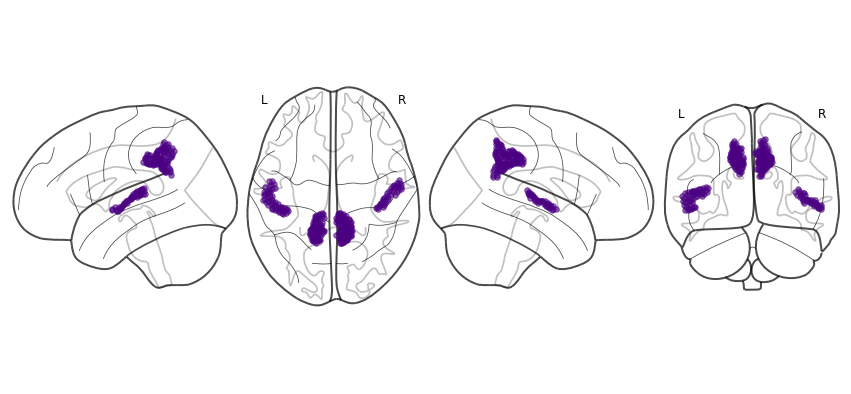

In [91]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 7))

# resection_nii = nb.as_closest_canonical(nb.load(sim.fresection))
display = plotting.plot_glass_brain(
            None, display_mode='lzry', figure=fig, axes=ax)

display.add_markers(sim.mni_resection, marker_color='indigo', alpha=0.6)


# SNR

To test how the signal to noise ratio influenses our detection we estimate it using the channels amplitude of the simulated events.

Signal to noise ratio was defined as following:

$$10*\log_{10} \left( \frac{1}{N_{ch}}\sum_{k=1}^{N_{ch}} \frac{\frac{1}{N_{tr}}\sum_{t=1}^{N_{tr}}a_{k}^2}{\frac{1}{N_{tr}}\sum_{t=1}^{N_{tr}}s_{k}^2} \right) \tag{1}$$

where $a_{k}^2$ is the mean $amplitude^2$ around the peak (+-20 ms) of the channel $k$, $s_{k}^2$ is the noise variance of this channel, $N_{tr}$ is number of trials and $N_{ch}$ is the number of channels. We estimated two SNR: SNR for all channels and SNR for the first 20 channels with the maximal amplitude.


We plot the average $amplitude^2$ across the trial for all channels and 20 with the maximal amplitude using `plot_epochs_snr`.

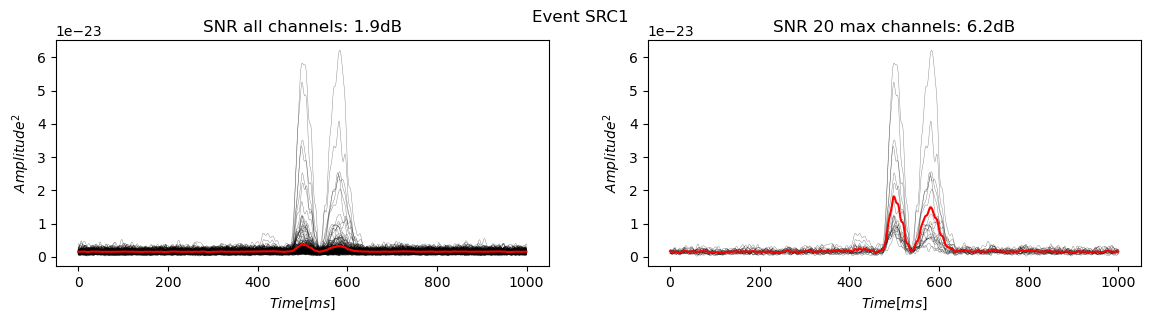

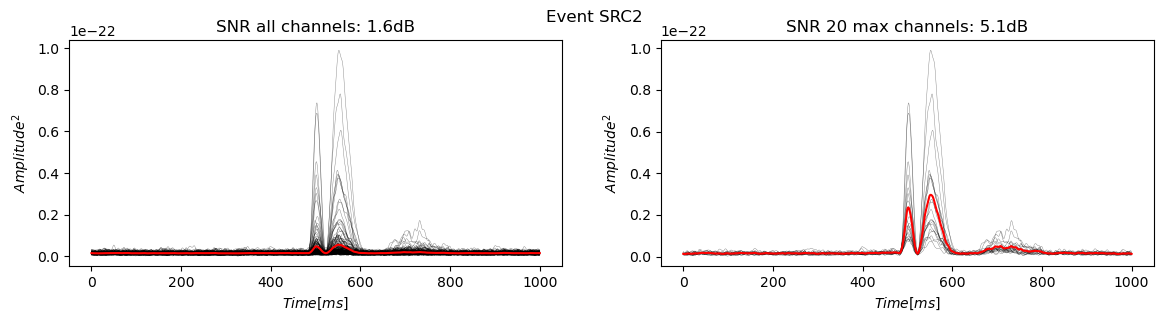

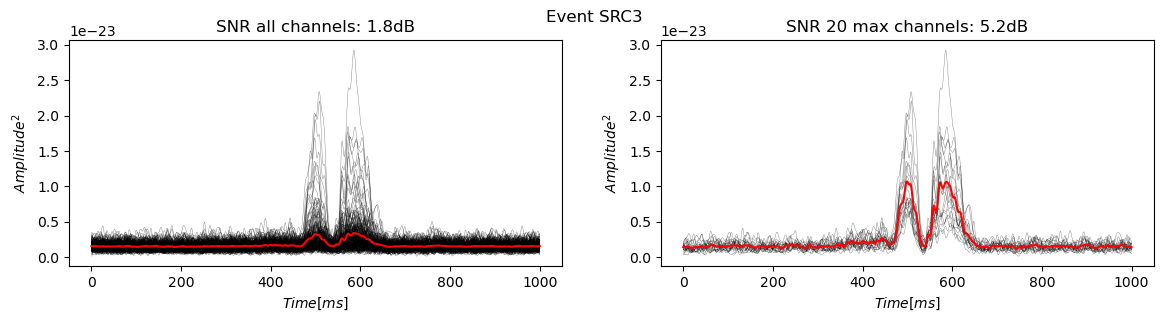

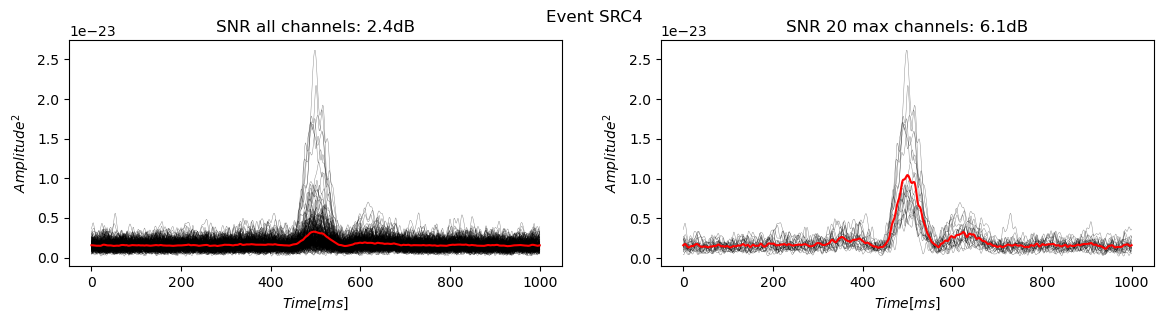

In [92]:
%matplotlib inline
from megspikes.visualization.visualization import plot_epochs_snr

for src in epochs_grad.event_id.keys():
    plot_epochs_snr(epochs_grad, src)
    plt.show()